# Initial clustering approach

This notebook demonstrates how clustering of feature vectors can be used to help improve posterior inference in basket trials.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import numpy as np
import pandas as pd
import arviz as az

In [4]:
import pylab as plt
import seaborn as sns
sns.set_context('poster')

In [5]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fclusterdata, fcluster, linkage, dendrogram
from scipy.spatial.distance import squareform
import scipy.cluster.hierarchy as shc

In [6]:
from pyBasket.env import Trial, TrueResponseSiteWithFeatures
from pyBasket.common import DEFAULT_EFFICACY_CUTOFF, DEFAULT_FUTILITY_CUTOFF

In [7]:
DEBUG = True

In [8]:
num_burn_in = 1E5
num_posterior_samples = 1E5
num_chains = None # let pymc decide

In [9]:
if DEBUG:
    num_burn_in = 5E4
    num_posterior_samples = 5E4
    num_chains = 1

### Generate data

Similar set-up to CBHM paper.

In [10]:
K = 6    # the number of groups
p0 = 0.20 # null response rate
p1 = 0.40 # target response rate

true_response_rates = [p0, p0, p1, p1, p1, p1]
enrollment = [10, 10]

n = 100
dim = 8
pvals_map = {
    p0: [1/10] * dim,
    p1: ([0.05] * int(dim/2)) + ([0.15] * int(dim/2))
}

sites = []
for k in range(K):
    true_response_rate = true_response_rates[k]
    pvals = pvals_map[true_response_rate]
    site = TrueResponseSiteWithFeatures(k, true_response_rate, enrollment, n, pvals)
    sites.append(site)

evaluate_interim = [True, True] # evaluate every interim stage
analysis_names = ['independent', 'hierarchical', 'bhm']

In [11]:
pd1a = sites[0].enroll()
pd1a

PatientData:
responses [1 1 1 0 0 0 0 0 0 0]
features
[[17  5 17 14  8  5  6 28]
 [ 7  6 16 10  8 14 14 25]
 [ 8 15 14  8 10  9  2 34]
 [12 13  8  9 14  9  6 29]
 [13  8 12  8 13  4 13 29]
 [16 13  8 11  7  7  6 32]
 [10  8 11  6  6 17 11 31]
 [14 13  9 12  5 11  6 30]
 [12  9  9 13  7 15 11 24]
 [ 9  6 13 12 12 11  8 29]]

In [12]:
pd2 = sites[-1].enroll()
pd2

PatientData:
responses [0 0 1 0 1 1 0 1 0 0]
features
[[ 6  2  6  6 13 14 19 34]
 [ 2  3  5  8 17 16 15 34]
 [ 3  7  7  4  9 20  8 42]
 [ 2  3  5  5 15 18 14 38]
 [ 4  5  5  6  7 20 15 38]
 [ 8  3  3  3 17 16 18 32]
 [ 6  4  4  2 16 19 17 32]
 [ 2  3  5  5 16 25 14 30]
 [ 3  4  7  7 20 13 10 36]
 [ 5  4  7  2 20 17 10 35]]

In [13]:
futility_cutoff = DEFAULT_FUTILITY_CUTOFF
efficacy_cutoff = DEFAULT_EFFICACY_CUTOFF
early_futility_stop = True
early_efficacy_stop = False

In [14]:
trial = Trial(K, p0, p1, sites, evaluate_interim, 
              num_burn_in, num_posterior_samples, analysis_names, 
              futility_cutoff=futility_cutoff, efficacy_cutoff=efficacy_cutoff,
              early_futility_stop=early_futility_stop,
              early_efficacy_stop=early_efficacy_stop,              
              num_chains=num_chains)

In [15]:
# done = trial.reset()
# while not done:
#     done = trial.step()

In [16]:
done = trial.reset()

In [17]:
self = trial

In [18]:
from pyBasket.common import DEFAULT_EFFICACY_CUTOFF, DEFAULT_FUTILITY_CUTOFF, DEFAULT_NUM_CHAINS, \
    GROUP_STATUS_OPEN, DEFAULT_EARLY_FUTILITY_STOP, DEFAULT_EARLY_EFFICACY_STOP, \
    GROUP_STATUS_EARLY_STOP_FUTILE, GROUP_STATUS_EARLY_STOP_EFFECTIVE, \
    GROUP_STATUS_COMPLETED_EFFECTIVE, GROUP_STATUS_COMPLETED_INEFFECTIVE

In [19]:
for k in range(self.K):
    site = self.sites[k]
    patient_data = site.enroll()

    # register new patients to the right group in each model
    for analysis_name in self.analysis_names:
        model = self.analyses[analysis_name]
        group = model.groups[k]
        if group.status == GROUP_STATUS_OPEN:
            group.register(patient_data)
        print('Analysis', analysis_name, group)
    print()


Analysis independent Group 0 (OPEN): 3/10
Analysis hierarchical Group 0 (OPEN): 3/10
Analysis bhm Group 0 (OPEN): 3/10

Analysis independent Group 1 (OPEN): 1/10
Analysis hierarchical Group 1 (OPEN): 1/10
Analysis bhm Group 1 (OPEN): 1/10

Analysis independent Group 2 (OPEN): 5/10
Analysis hierarchical Group 2 (OPEN): 5/10
Analysis bhm Group 2 (OPEN): 5/10

Analysis independent Group 3 (OPEN): 3/10
Analysis hierarchical Group 3 (OPEN): 3/10
Analysis bhm Group 3 (OPEN): 3/10

Analysis independent Group 4 (OPEN): 5/10
Analysis hierarchical Group 4 (OPEN): 5/10
Analysis bhm Group 4 (OPEN): 5/10

Analysis independent Group 5 (OPEN): 5/10
Analysis hierarchical Group 5 (OPEN): 5/10
Analysis bhm Group 5 (OPEN): 5/10



### Generate feature matrix for 60 patients (10 each in 6 baskets)

In [20]:
all_features = []
all_classes = []
all_responses = []
for group in model.groups:
    features = group.features
    all_features.append(features)   
    
    N = group.features.shape[0]
    group_class = [group.idx] * N
    all_classes.extend(group_class)
    
    all_responses.extend(group.responses)
    
all_features = np.concatenate(all_features)
all_classes = np.array(all_classes)
all_responses = np.array(all_responses)
all_response_rates = np.array([true_response_rates[k] for k in all_classes])
all_features.shape, all_features, all_classes.shape, all_classes, all_responses, all_response_rates

((60, 8),
 array([[10,  9, 11, 11,  5, 14, 10, 30],
        [12,  9, 14,  8,  9, 10,  4, 34],
        [ 8, 12, 11, 12, 10, 17, 11, 19],
        [ 7, 10,  6, 11, 18, 12,  9, 27],
        [18,  7, 10, 14,  5,  8,  8, 30],
        [11, 13, 13, 14,  6, 14,  6, 23],
        [ 6,  8, 14,  8,  8, 15, 13, 28],
        [10,  9,  5, 10, 12,  9, 12, 33],
        [ 6, 14, 13, 11, 11,  9,  5, 31],
        [ 9, 12,  8, 10, 12, 14,  8, 27],
        [11,  5, 12, 12,  5, 12,  7, 36],
        [ 8, 12, 10, 12, 10, 10, 10, 28],
        [10, 12, 10,  9, 12, 10, 12, 25],
        [12,  7,  7, 10, 12, 13,  8, 31],
        [11,  9, 11, 15,  5,  9, 10, 30],
        [ 9, 13, 13,  7,  6,  8,  4, 40],
        [12,  6, 14, 12, 11, 11,  7, 27],
        [ 8, 11,  8,  5, 10, 14, 15, 29],
        [ 7, 12, 11, 13, 12, 10,  5, 30],
        [ 7,  9,  9, 13,  9, 13, 10, 30],
        [ 7,  8,  6,  3, 21, 17, 13, 25],
        [ 6,  7,  1,  0, 11, 14, 19, 42],
        [ 5,  2,  6,  1, 18, 16, 19, 33],
        [ 7,  2,  6,  2,

### PCA shows 2 clusters

In [21]:
pca = PCA(n_components=5)
pcs = pca.fit_transform(all_features)
pca.explained_variance_ratio_.cumsum()

array([0.4641037 , 0.72159467, 0.81699178, 0.87253871, 0.92065915])

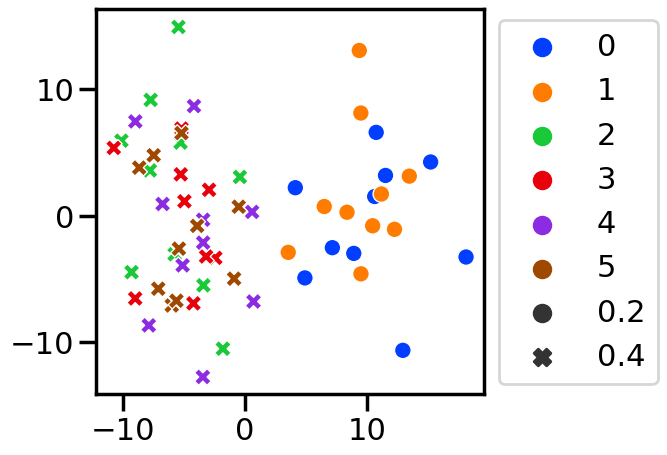

In [41]:
pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
plt.figure(figsize=(5, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=all_classes, palette='bright', style=all_response_rates)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

### Compute distance matrix

In [32]:
# a custom function that computes:
# the Euclidean distance if p1 and p2 are in different baskets
# or, returns 0 distance if p1 and p2 are in the same basket
def mydist(p1, p2, c1, c2):
    if c1 == c2:
        return 0
    diff = p1 - p2
    return np.vdot(diff, diff) ** 0.5

N = all_features.shape[0]
dist = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        p1 = all_features[i]
        p2 = all_features[j]
        c1 = all_classes[i]
        c2 = all_classes[j]
        dist[i, j] = mydist(p1, p2, c1, c2)

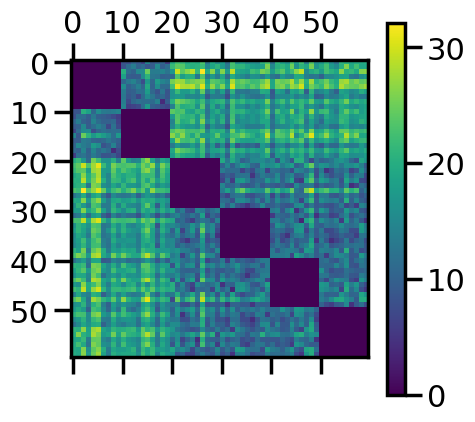

In [33]:
plt.matshow(dist)
plt.colorbar()

### Hierarchical clustering with custom distance matrix

In [34]:
condensed_dist = squareform(dist)
Z = linkage(condensed_dist, method='ward')

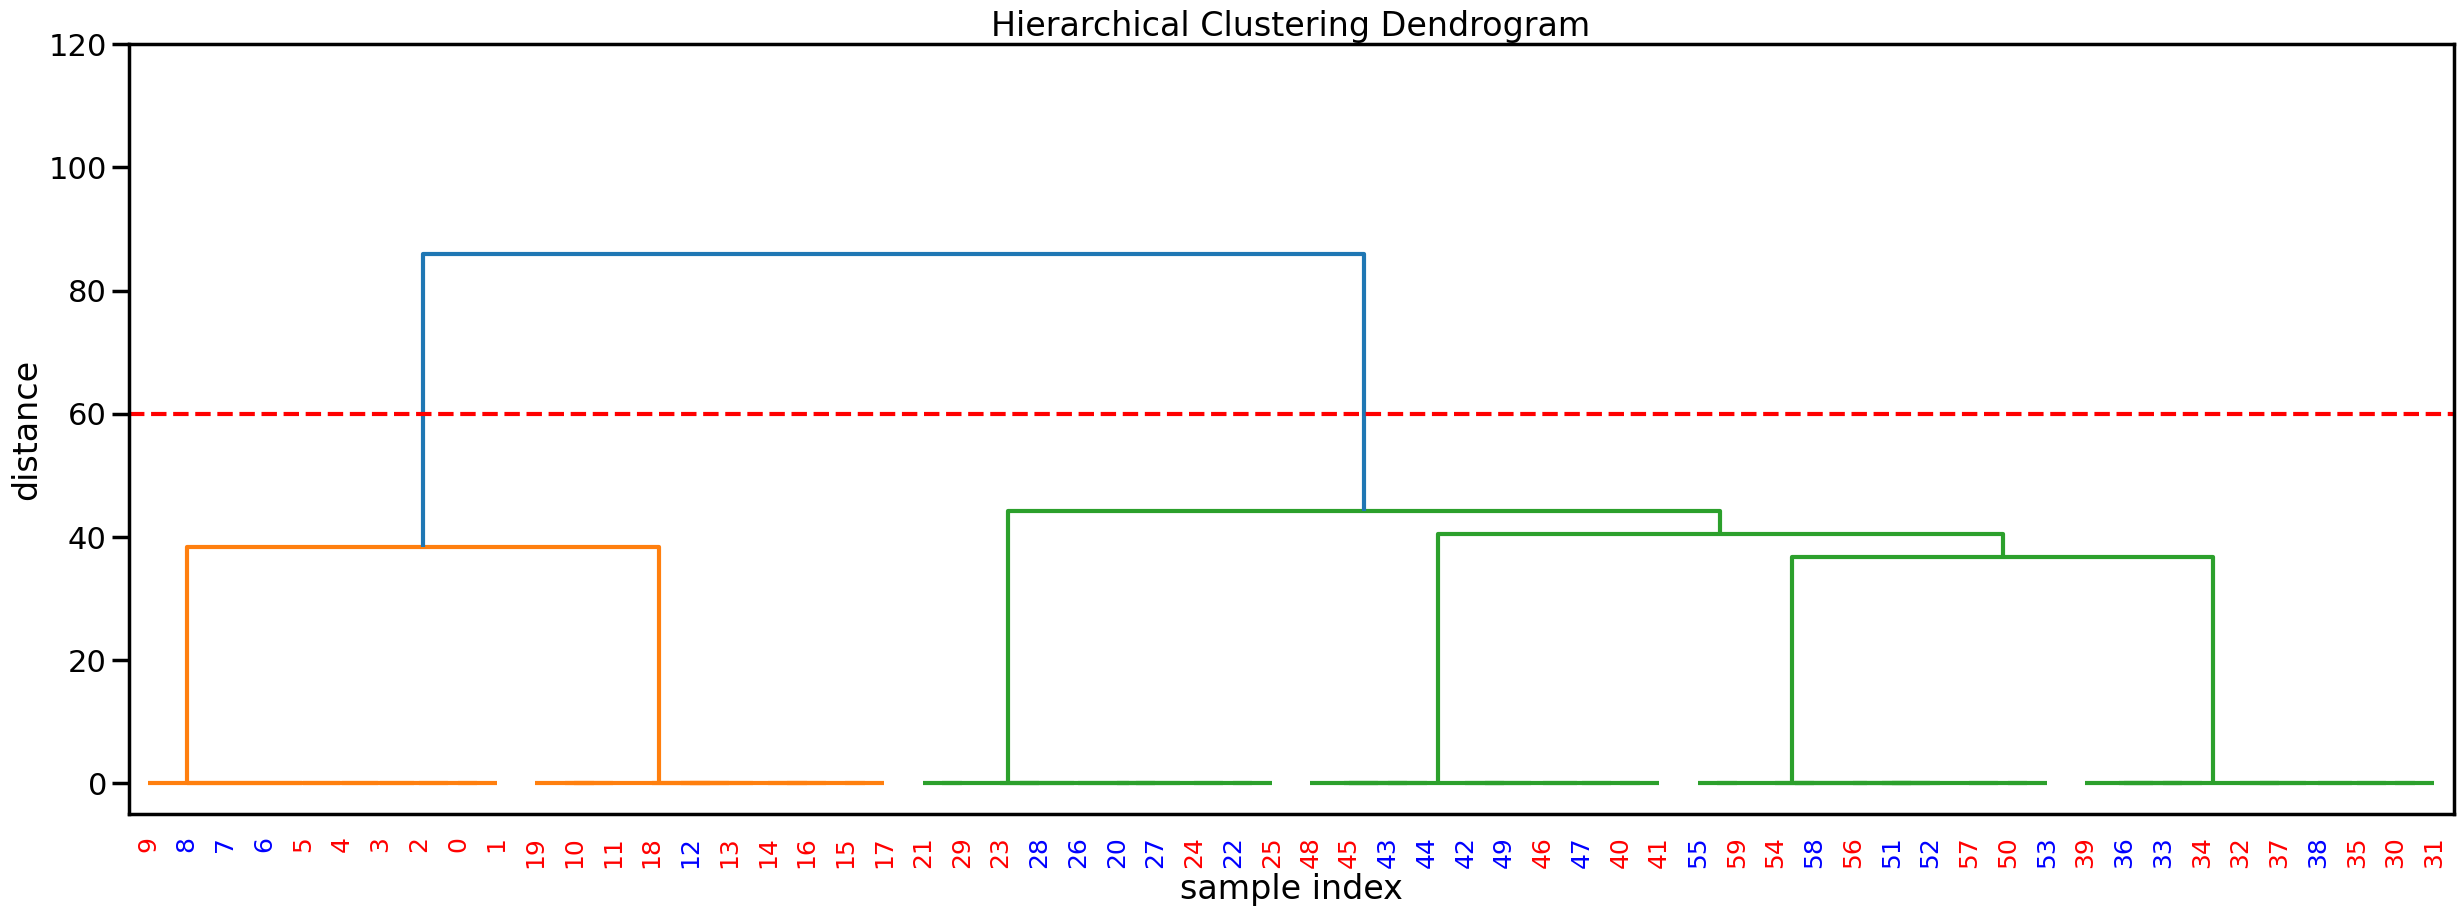

In [67]:
plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18,  # font size for the x axis labels
)
plt.ylim([-5, 120])
plt.axhline(y = 60, color = 'r', linestyle = '--')
for text in plt.gca().get_xticklabels():
    pos = int(text.get_text())
    if all_responses[pos] == 1:
        text.set_color('blue')
    else:
        text.set_color('red')        

We can now use the cluster assignment below to help improve response rate.

In [85]:
max_d = 60
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [86]:
len(clusters)

60

### Infer responses per basket

In [68]:
done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 ##########

Analysis independent Group 0 (OPEN): 3/10
Analysis hierarchical Group 0 (OPEN): 3/10
Analysis bhm Group 0 (OPEN): 3/10

Analysis independent Group 1 (OPEN): 4/10
Analysis hierarchical Group 1 (OPEN): 4/10
Analysis bhm Group 1 (OPEN): 4/10

Analysis independent Group 2 (OPEN): 5/10
Analysis hierarchical Group 2 (OPEN): 5/10
Analysis bhm Group 2 (OPEN): 5/10

Analysis independent Group 3 (OPEN): 3/10
Analysis hierarchical Group 3 (OPEN): 3/10
Analysis bhm Group 3 (OPEN): 3/10

Analysis independent Group 4 (OPEN): 3/10
Analysis hierarchical Group 4 (OPEN): 3/10
Analysis bhm Group 4 (OPEN): 3/10

Analysis independent Group 5 (OPEN): 5/10
Analysis hierarchical Group 5 (OPEN): 5/10
Analysis bhm Group 5 (OPEN): 5/10

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 36 seconds.


,prob,futile,effective
k,,,
0,0.57206,False,False
1,0.78694,False,False
2,0.92384,False,True
3,0.56770,False,False
4,0.57012,False,False
5,0.92018,False,True


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 89 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.73084,False,False
1,0.83670,False,False
2,0.91696,False,True
3,0.73038,False,False
4,0.73124,False,False
5,0.91696,False,True


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 69 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.64192,False,False
1,0.84118,False,False
2,0.94832,False,True
3,0.64586,False,False
4,0.64974,False,False
5,0.94552,False,True



########## Stage=1 ##########

Analysis independent Group 0 (OPEN): 4/20
Analysis hierarchical Group 0 (OPEN): 4/20
Analysis bhm Group 0 (OPEN): 4/20

Analysis independent Group 1 (OPEN): 4/20
Analysis hierarchical Group 1 (OPEN): 4/20
Analysis bhm Group 1 (OPEN): 4/20

Analysis independent Group 2 (OPEN): 9/20
Analysis hierarchical Group 2 (OPEN): 9/20
Analysis bhm Group 2 (OPEN): 9/20

Analysis independent Group 3 (OPEN): 8/20
Analysis hierarchical Group 3 (OPEN): 8/20
Analysis bhm Group 3 (OPEN): 8/20

Analysis independent Group 4 (OPEN): 7/20
Analysis hierarchical Group 4 (OPEN): 7/20
Analysis bhm Group 4 (OPEN): 7/20

Analysis independent Group 5 (OPEN): 10/20
Analysis hierarchical Group 5 (OPEN): 10/20
Analysis bhm Group 5 (OPEN): 10/20

Running inference for: independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 38 seconds.


,prob,futile,effective
k,,,
0,0.58370,None,False
1,0.58504,None,False
2,0.99522,None,True
3,0.98496,None,True
4,0.95654,None,True
5,0.99882,None,True


Running inference for: hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 87 seconds.


,prob,futile,effective
k,,,
0,0.83066,None,False
1,0.83248,None,False
2,0.99686,None,True
3,0.99204,None,True
4,0.98050,None,True
5,0.99920,None,True


Running inference for: bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 50_000 tune and 50_000 draw iterations (50_000 + 50_000 draws total) took 69 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.59826,None,False
1,0.60002,None,False
2,0.99688,None,True
3,0.98654,None,True
4,0.95940,None,True
5,0.99900,None,True


### Independent

In [69]:
analysis_name = analysis_names[0]
analysis_name

'independent'

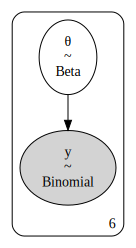

In [70]:
trial.visualise_model(analysis_name)

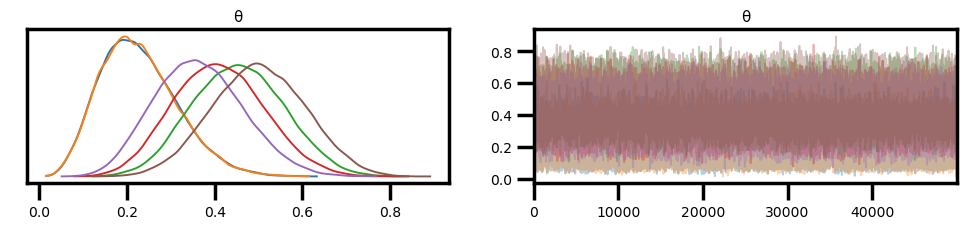

In [71]:
trial.plot_trace(analysis_name, -1)

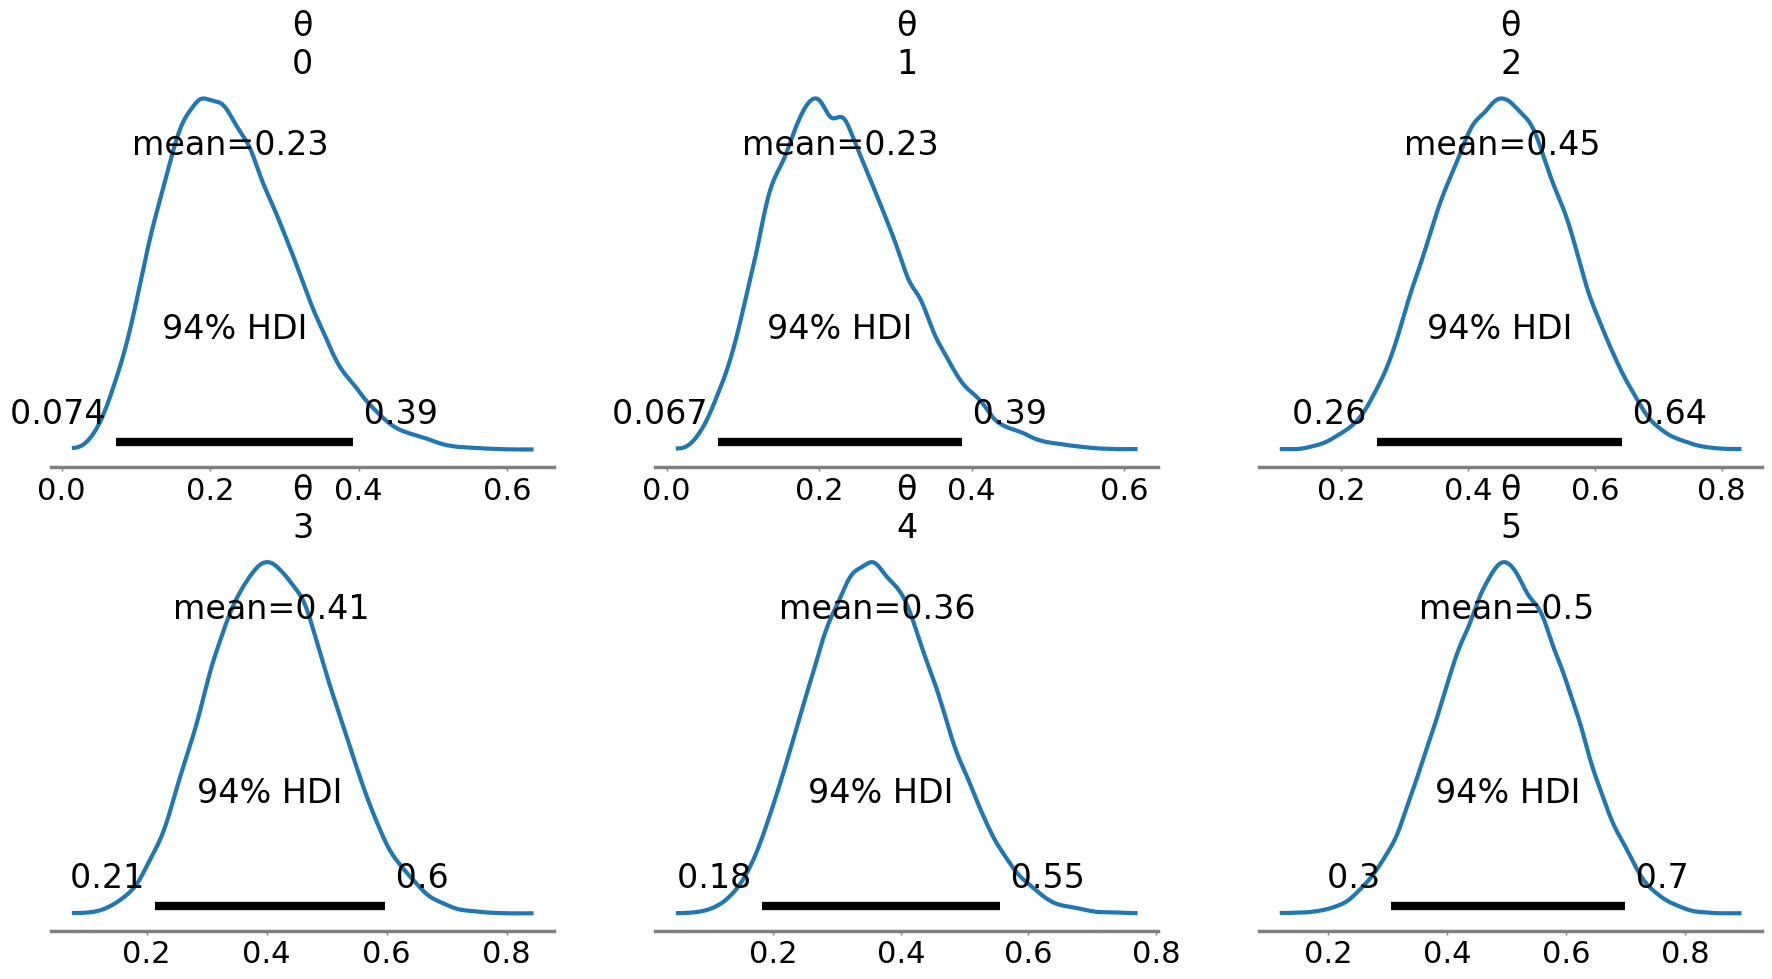

In [72]:
trial.plot_posterior(analysis_name, -1)

In [73]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,COMPLETED_INEFFECTIVE,4,20
1,COMPLETED_INEFFECTIVE,4,20
2,COMPLETED_EFFECTIVE,9,20
3,COMPLETED_EFFECTIVE,8,20
4,COMPLETED_EFFECTIVE,7,20
5,COMPLETED_EFFECTIVE,10,20


### Hierarchical

In [74]:
analysis_name = analysis_names[1]
analysis_name

'hierarchical'

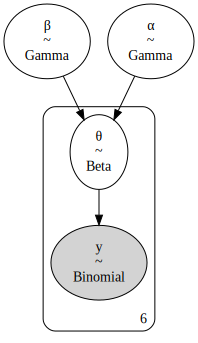

In [75]:
trial.visualise_model(analysis_name)

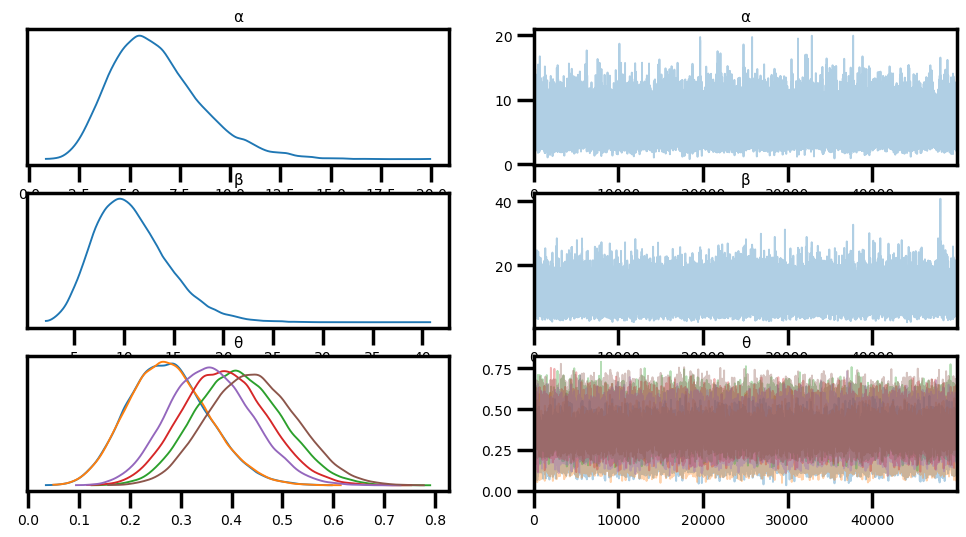

In [76]:
trial.plot_trace(analysis_name, -1)

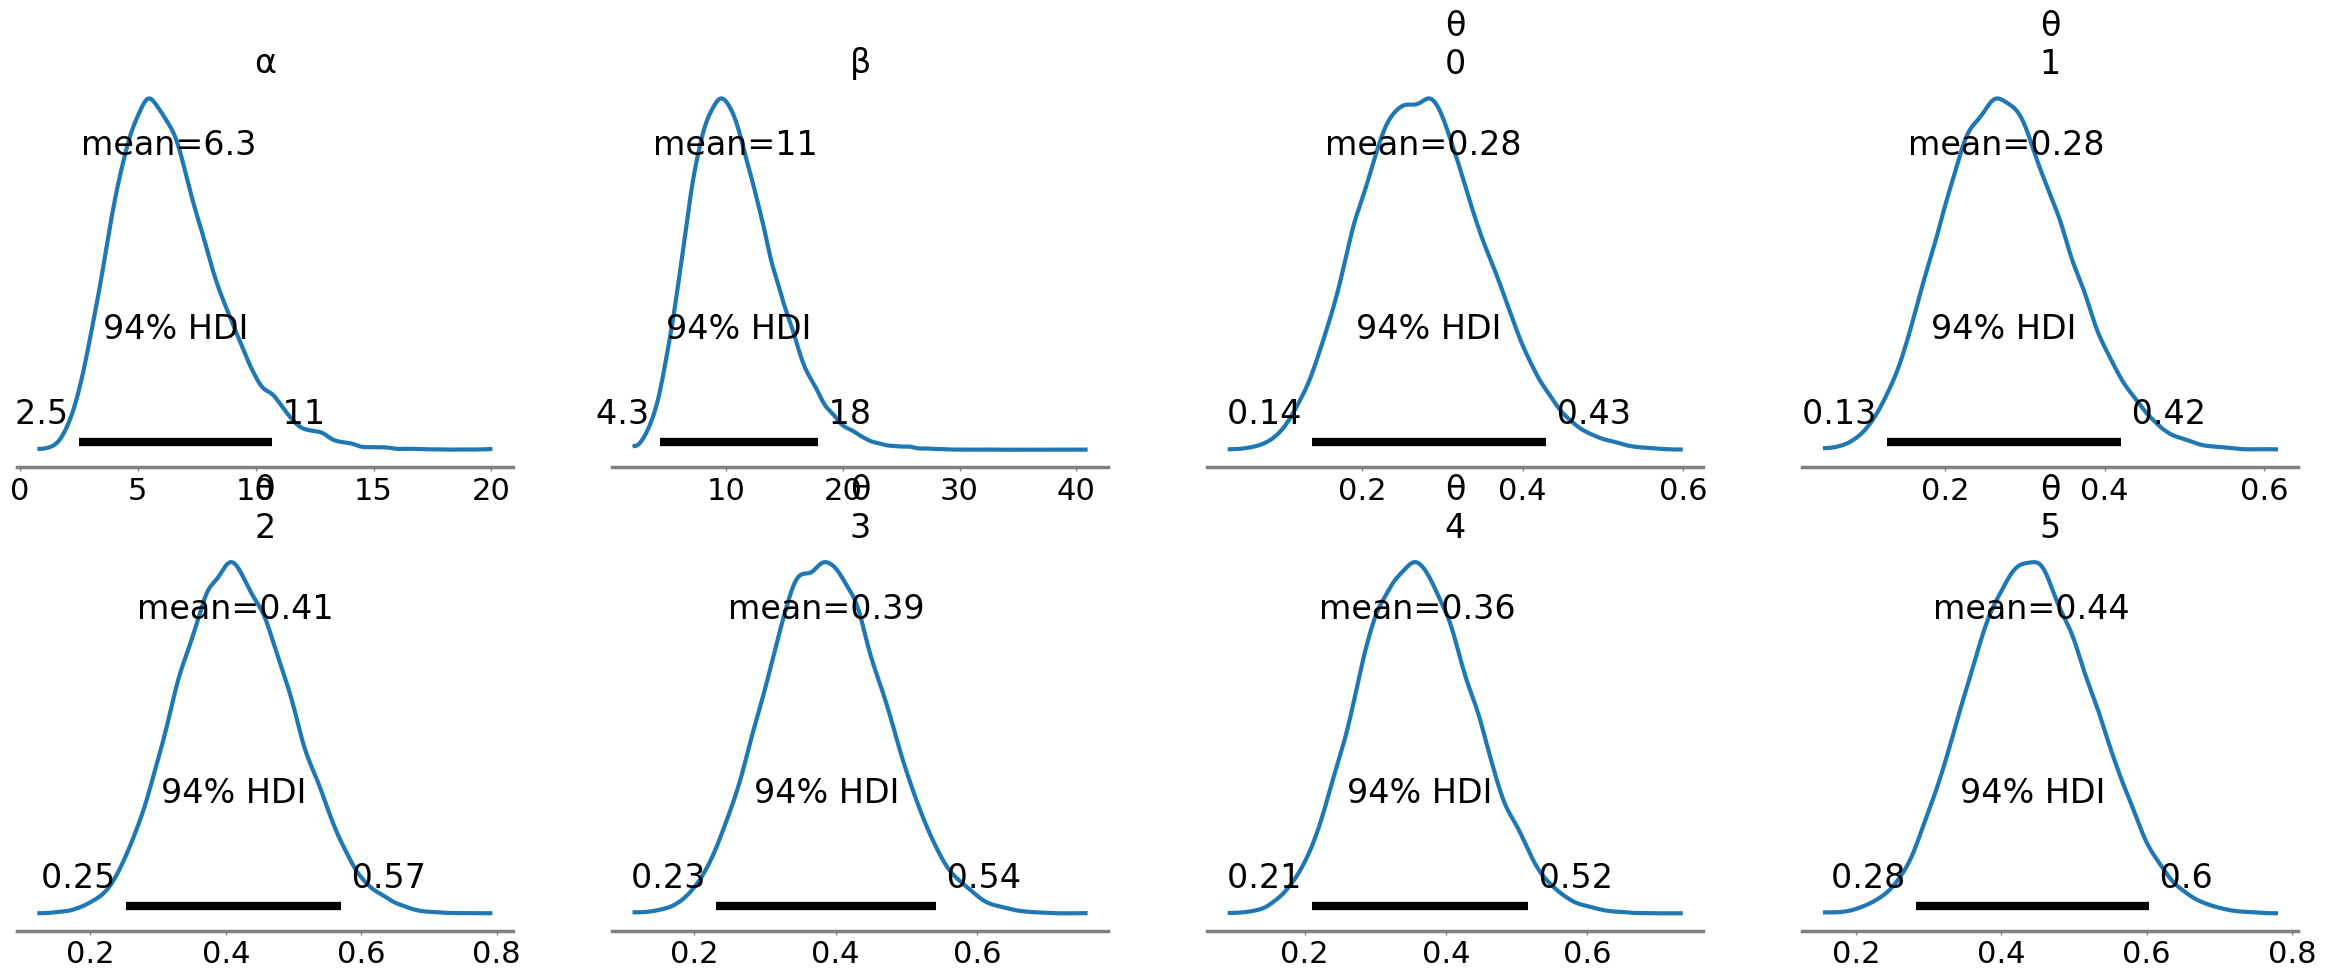

In [77]:
trial.plot_posterior(analysis_name, -1)

In [78]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,COMPLETED_INEFFECTIVE,4,20
1,COMPLETED_INEFFECTIVE,4,20
2,COMPLETED_EFFECTIVE,9,20
3,COMPLETED_EFFECTIVE,8,20
4,COMPLETED_EFFECTIVE,7,20
5,COMPLETED_EFFECTIVE,10,20


### BHM

In [79]:
analysis_name = analysis_names[2]
analysis_name

'bhm'

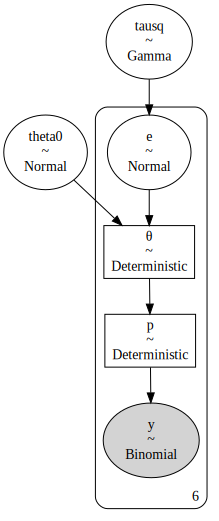

In [80]:
trial.visualise_model(analysis_name)

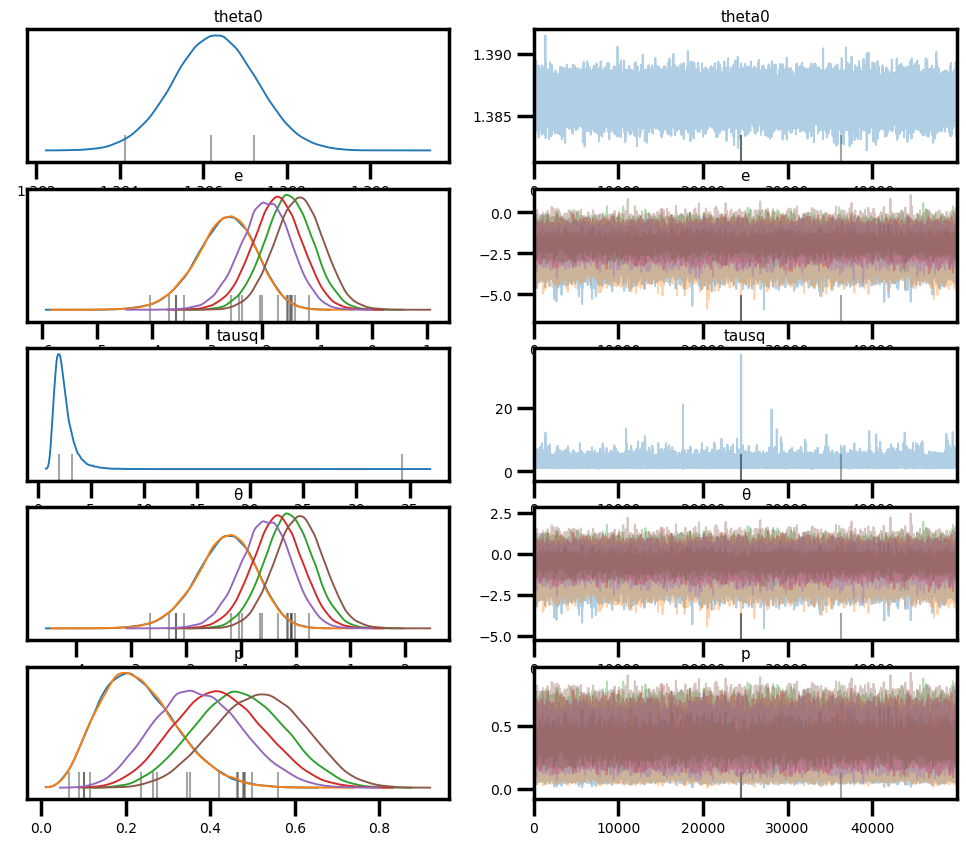

In [81]:
trial.plot_trace(analysis_name, -1)

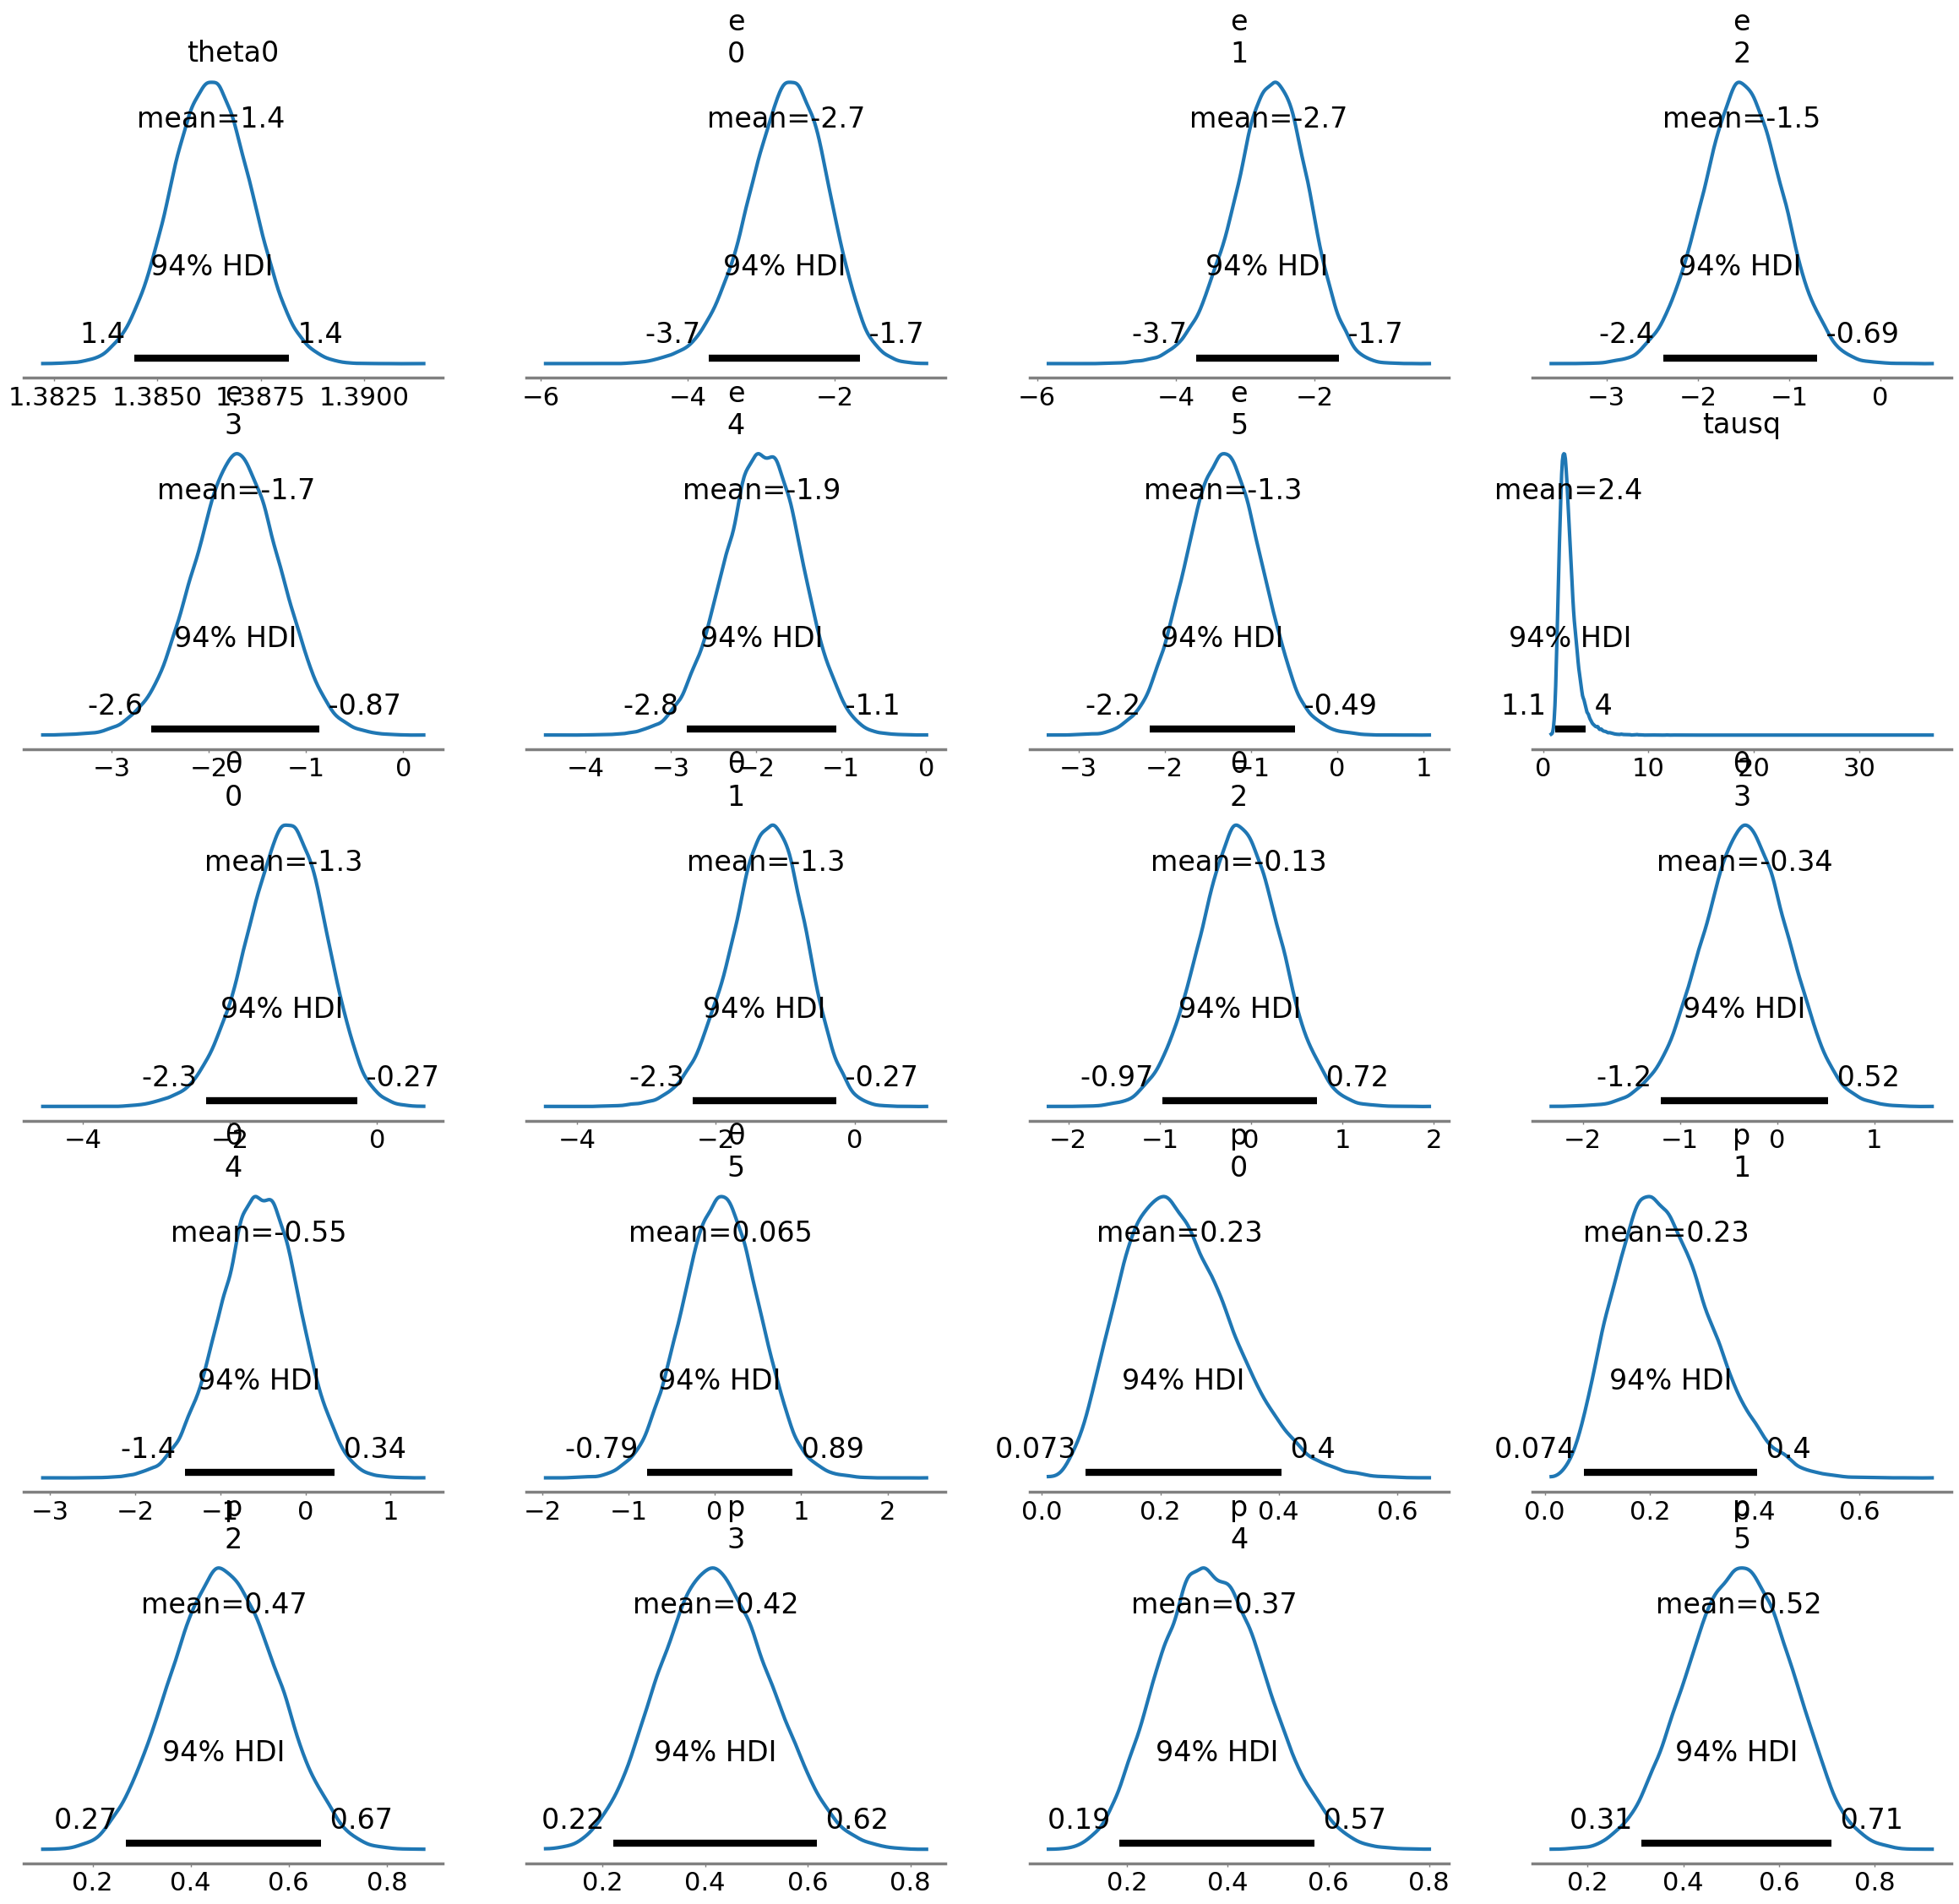

In [82]:
trial.plot_posterior(analysis_name, -1)

In [83]:
trial.final_report(analysis_name)

,status,nnz,total
k,,,
0,COMPLETED_INEFFECTIVE,4,20
1,COMPLETED_INEFFECTIVE,4,20
2,COMPLETED_EFFECTIVE,9,20
3,COMPLETED_EFFECTIVE,8,20
4,COMPLETED_EFFECTIVE,7,20
5,COMPLETED_EFFECTIVE,10,20
